# Chess (King-Rook vs. King) Supervised Classification

Authors:

*   A00843399 Paola Azeneth Castillo Gutiérrez  
*   A01195880 Alejandro Gonzalez Saenz
*   A01272597 Daniela Laguna Macotela






## Summary

This report analyzes and compares the performance of three classification algorithms:k-Nearest Neighbors (knn), Decision Tree, and Random Forest, on a chess endgame dataset featuring King-Rook vs. King positions. The goal is to predict the depth of win based on board configurations dataset. The models are evaluated using accuracy, precision, recall, and F1 score to determine which approach best predicts the results in the dataset.The best model was the Random Forest with a weighted accuracy of 0.84 and f1-score of 0.84 using 250 optimal estimators and a max_depth=20.

## Description of the work

### Dataset Selection
Taking the rightmost digit of the sum of the rightmost digit of the teammates id:     

*   A00843399
*   A01195880
*   A01272597

9 + 0 + 7 = 16 this means we are assigned the problem number 6




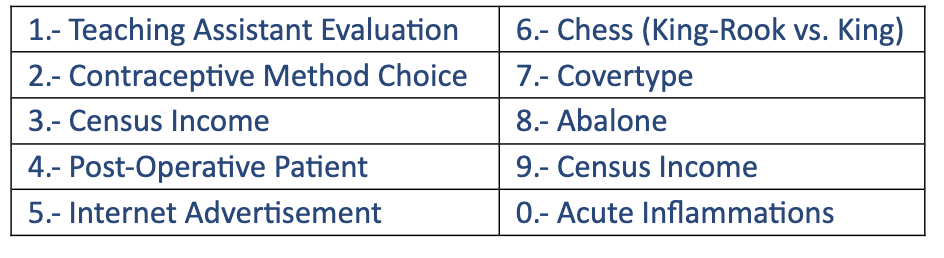

### Chess (King-Rook vs. King) Database description  

An Inductive Logic Programming (ILP) or relational learning framework is assumed (Muggleton, 1992). The learning system is provided with examples of chess positions described only by the coordinates of the pieces on the board. Background knowledge in the form of row and column differences is also supplied. The relations necessary to form a correct and concise classifier for the target concept must be discovered by the learning system (the examples already provide a complete extensional definition). The task is closely related to Quinlan's (1983) application of ID3 to classify White King and Rook against Black King and Knight (KRKN) positions as lost 2-ply or lost 3-ply. The framework is similar in that the example positions supply only low-grade data. An important difference is that additional background predicates of the kind supplied in the KRKN study via hand-crafted attributes are not provided for this KRK domain (Bain,2024).  

Number of features = 6   
Number of instances = 28056

The optimal depth-of-win for White in 0 to 16 moves, otherwise drawn {draw, zero, one, two, ..., sixteen}

In [ ]:
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo
chess_king_rook_vs_king = fetch_ucirepo(id=23) # Fetch Dataset
X = chess_king_rook_vs_king.data.features      # Data (as Pandas Dataframe)
y = chess_king_rook_vs_king.data.targets       # Classes

### Problem Conceptualization

Chess is a game where luck does not determine the outcome. This means that every possible move can be calculated, and the conditions change with each different move from the opponent. In this problem, we are considering only a small part of the huge possibilities in chess. We are analyzing possible endgames where we have the white rook and white king, while our opponent only has their black king.

**The Chess Board**

In chess, the battlefield is limited to an 8×8 grid. The x-axis is defined by a, b, c, d, e, f, g, h, and the y-axis is defined by 1, 2, 3, 4, 5, 6, 7, 8. This helps us locate positions on the board using coordinates and define each movement made by the pieces.

**Dataset Information**

The dataset provides 28,056 board positions for this endgame. Each position includes the current position (row and column) of the white king, white rook, and black king.

**The problem**

The objective is for the machine learning models to evaluate how good each position is, in other words, in how many moves the white pieces can win, assuming our opponent plays perfectly and always makes optimal moves (which rarely happens in classical chess).

These classifications are based on the possible game outcomes:
- Draw
- "Zero" - when white wins immediately
- "One" - when white wins in one move
- And so on up to "Sixteen" - when white wins in 16 moves

A perceptive question would be why we don't consider the possibility of the black king winning. This is because, under the problem conditions, we're assuming that white also always plays optimally (meaning they won't accidentally lose their rook). Additionally, it's impossible for the black king alone to deliver checkmate, as a minimum of two pieces is required (Capablanca,1921).


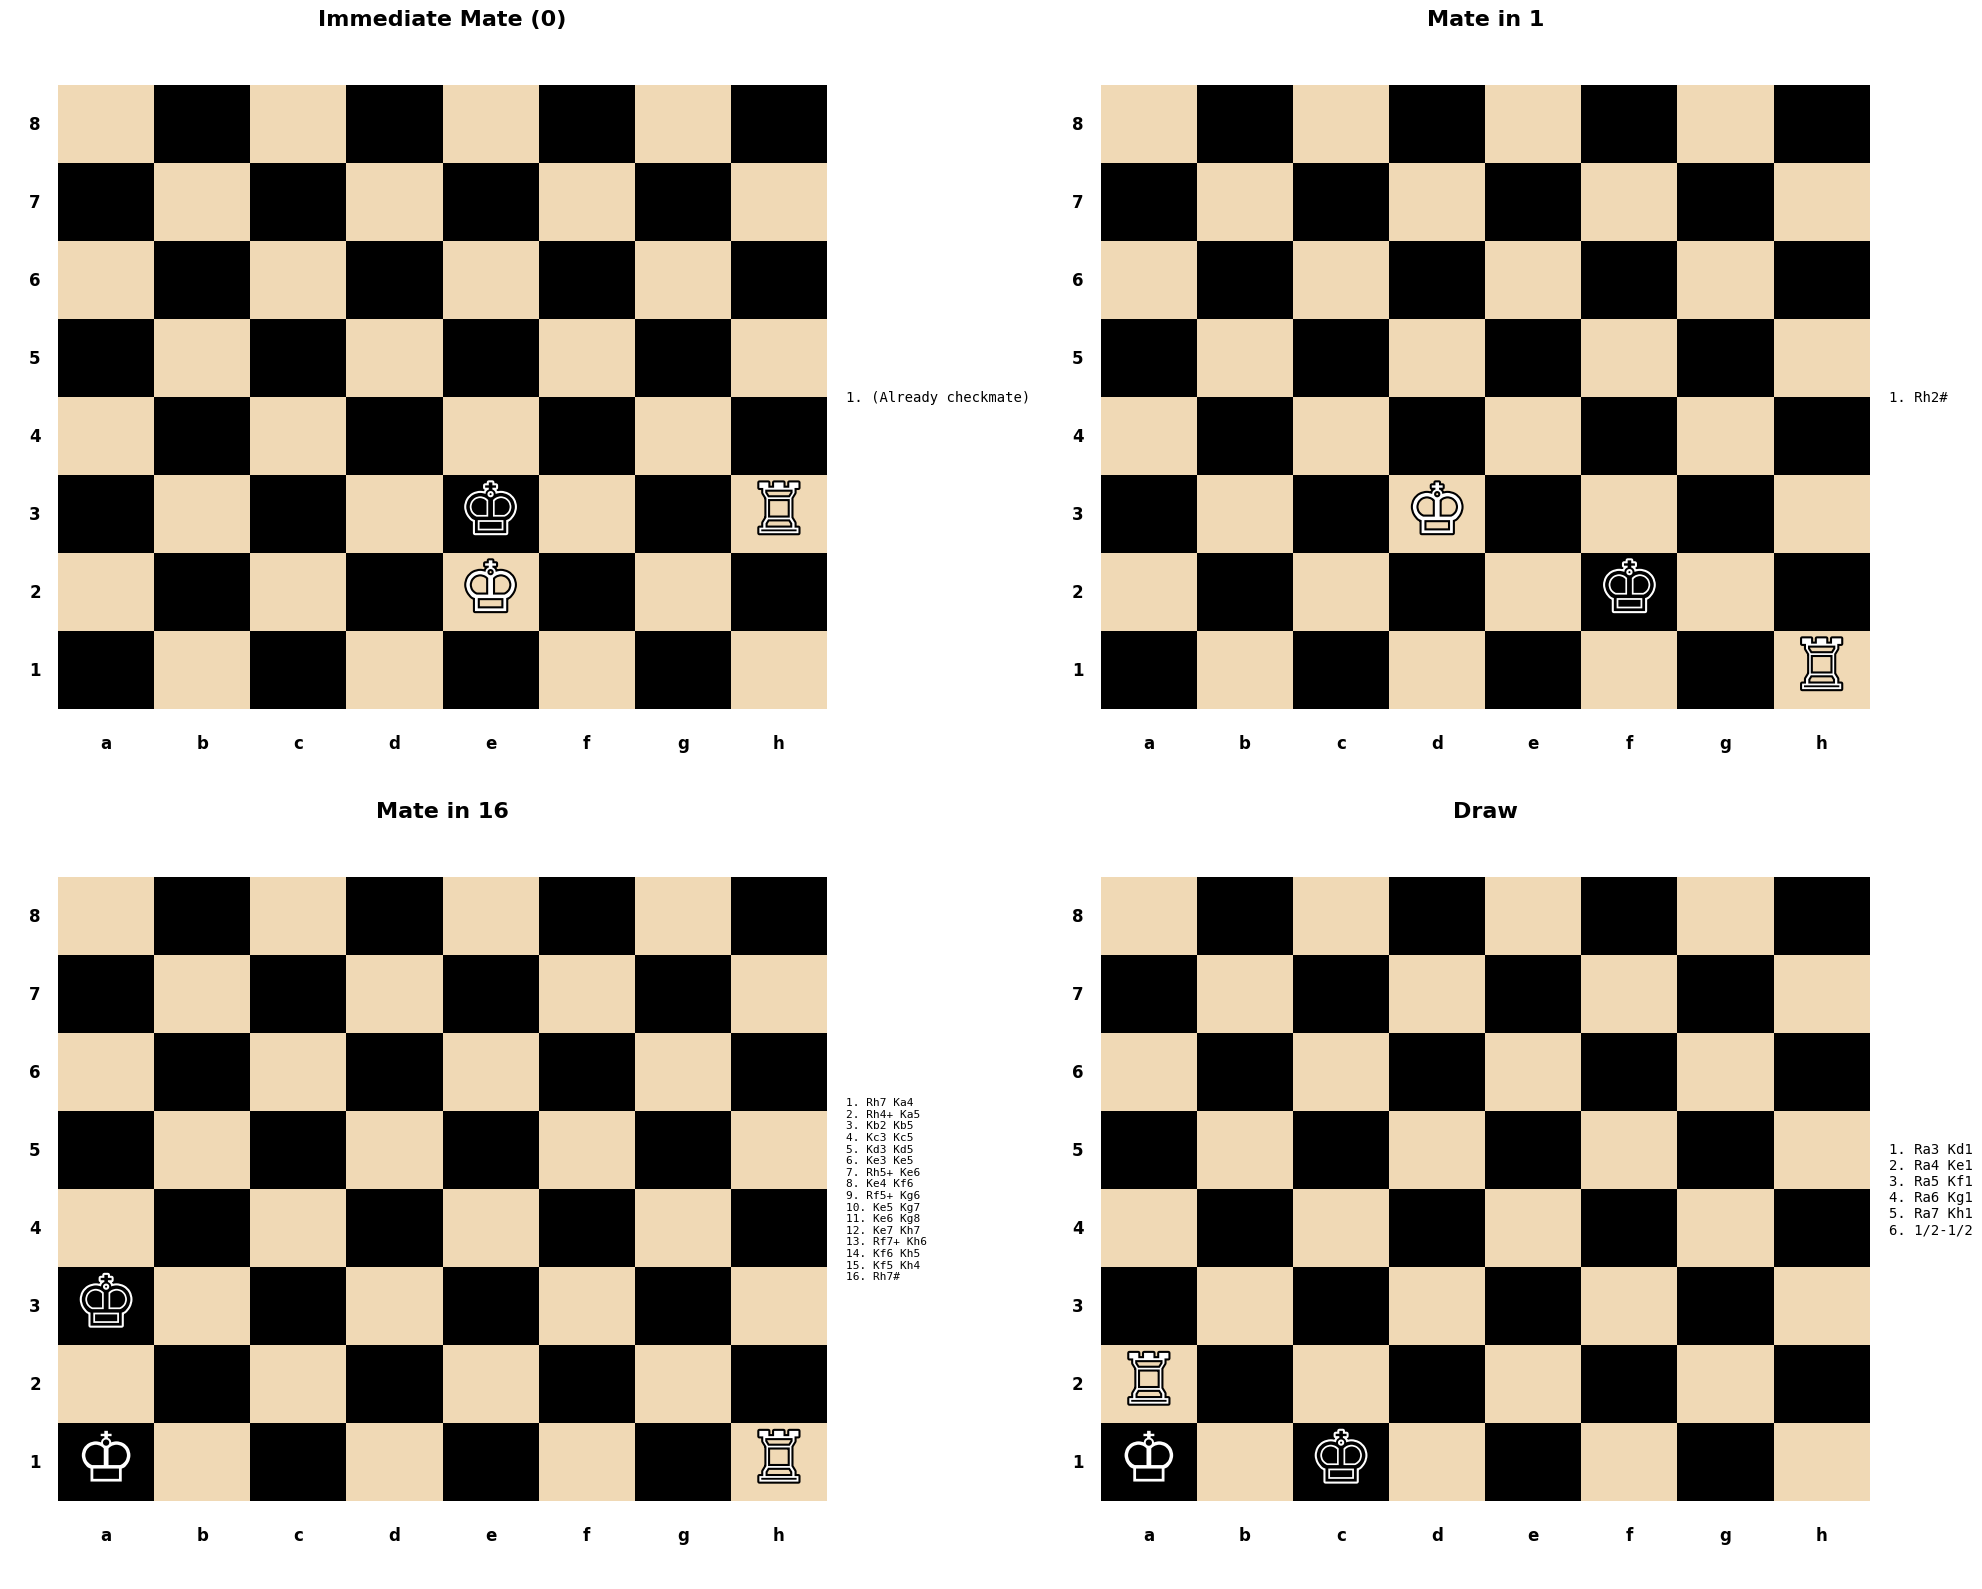

In real chess, there exists the possibility of winning in more than the sixteen moves, but that analysis would make the problem more complex.

### Libraries


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn import tree
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

### Exploration of the data


We start by getting the big picture of the dataset structure and understanding the data types present.

In [ ]:
print(chess_king_rook_vs_king.data.original.info)
print(chess_king_rook_vs_king.data.original.columns)
print(chess_king_rook_vs_king.metadata)  # Metadata
print(chess_king_rook_vs_king.variables) # Variable Information

<bound method DataFrame.info of       white-king-file  white-king-rank white-rook-file  white-rook-rank  \
0                   a                1               b                3   
1                   a                1               c                1   
2                   a                1               c                1   
3                   a                1               c                1   
4                   a                1               c                2   
...               ...              ...             ...              ...   
28051               b                1               g                7   
28052               b                1               g                7   
28053               b                1               g                7   
28054               b                1               g                7   
28055               b                1               g                7   

      black-king-file  black-king-rank white-depth-of-win  
0      

### Validation strategy

We chose to make a simple 80-20 split between the samples, with 80% dedicated for training the sklearn classifiers. The utility of this approach is to be able to see if the machine learning models are capable of identifying the rules of chess at different winning depths (executed moves) and knowing the bifurcating paths of each possible position.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,       # Ratio of 20% fixed for the test
    random_state=42,     # Seed for reproduction
    stratify=y           # Guarantees the proportion of classes(depths of wins)
)

The counts for each class represent the number of possible board positions from which white can win in a specific number of moves. As we can observe, due to the combinatorial nature of the problem and the rules of chess, the number of instances for each class varies significantly.Thus, the classes are not balanced.

In [ ]:
target_distribution = y['white-depth-of-win'].value_counts(normalize = False)
print(target_distribution)

white-depth-of-win
fourteen    4553
thirteen    4194
twelve      3597
eleven      2854
draw        2796
fifteen     2166
ten         1985
nine        1712
eight       1433
seven        683
six          592
five         471
sixteen      390
two          246
four         198
three         81
one           78
zero          27
Name: count, dtype: int64


###Measures used to compare Models



#### **Accuracy**

Measures how many predictions the model got right out of the total predictions. It is expressed as:
$${Accuracy} = \frac{\text{Correct Predictions}}{\text{Total Predictions}}$$

The higher the accuracy, the better.

#### **Precision**

Tells us how many of the predicted positive cases were actually correct.


$${Precision} = \frac{\text{True Positives}}{ \text{True Positives} + \text{False Positives}}$$

Higher precision is better.

#### **Recall**
Tells us how many actual positive cases were correctly predicted.

$$
{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
$$

A higher recall is better.

#### **F1 Score**
F1 Score is the mean of Precision and Recall. It balances both metrics into a single score.


$$
F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

Higher F1 the better, it is useful when both precision, and recall need to be high, and handles imbalanced datasets better than accuracy.



### Decision Tree


**Entropy and Information Gain**

The decision trees for this experiment use entropy calculation to determine which is the attribute with the most information gain.

**Entropy Formula**
Entropy measures node impurity. For a dataset $S$ with $K$ classes:

$$H(S) = -\sum_{k=1}^{K} p_k \log_2(p_k)$$

Where:
- $p_k = \frac{\text{samples from class } k}{\text{total samples in } S}$
- $\log_2$: Binary logarithm (base 2)

**Information Gain**
Information gain is the reduction in entropy after a dataset is split on an attribute:

$$\text{IG}(S, A) = H(S) - \sum_{v \in \text{Values}(A)} \frac{|S_v|}{|S|} H(S_v)$$

Where:
- $S$: Dataset before split
- $A$: Attribute to split on
- $S_v$: Subset of $S$ where attribute $A$ has value $v$
- $\text{Values}(A)$: Set of all possible values of attribute $A$

**CART Algorithm Formalization**

According to "The Elements of Statistical Learning" (Hastie, Tibshirani, Friedman), the Classification and Regression Tree (CART) algorithm formalizes the tree-growing process using the following elements:

**Classification Trees**
For classification trees, let:
- $R_m$ represent the region (or node) $m$
- $p_{mk}$ be the proportion of class $k$ observations in node $m$

$$p_{mk} = \frac{1}{N_m}\sum_{x_i \in R_m} I(y_i = k)$$

Where $N_m$ is the number of observations in region $R_m$.

The impurity measure for classification trees using entropy criterion is:

$$Q_m(\text{entropy}) = -\sum_{k=1}^{K} p_{mk} \log p_{mk}$$

**Split Selection**
For any split of a predictor $j$ at split point $s$, define the pair of half-planes:

$$R_L(j,s) = \{X|X_j \leq s\} \text{ and } R_R(j,s) = \{X|X_j > s\}$$

The algorithm finds the splitting variable $j$ and split point $s$ that solves:

$$\min_{j,s} [\min_{c_L} \sum_{x_i \in R_L(j,s)} L(y_i, c_L) + \min_{c_R} \sum_{x_i \in R_R(j,s)} L(y_i, c_R)]$$

Where $L(y_i, c)$ is the impurity measure.

**Tree Complexity and Regularization**
The full tree $T_0$ is grown until some minimum node size is reached. Then it's pruned using cost-complexity pruning:

$$C_\alpha(T) = \sum_{m=1}^{|T|} N_m Q_m(T) + \alpha |T|$$

Where:
- $|T|$ is the number of terminal nodes in tree $T$
- $Q_m(T)$ is the impurity measure in node $m$
- $\alpha$ is the complexity parameter

The parameter $\alpha \geq 0$ controls the trade-off between tree size and its goodness of fit to the training data. Larger values of $\alpha$ result in smaller trees.

In scikit-learn's implementation, the `max_depth` parameter directly controls the maximum depth of the tree, which is an alternative way to control complexity compared to the cost-complexity pruning described in the original CART algorithm.

The dataset categorizes all positions into classes from "immediate mate" (0) to "mate in 16 moves", plus "draw".
Each level in the tree could conceptually represent one move in the sequence but the tree doesn't have direct access to the chess rules or move sequences.
The optimal tree depth might differ from 16 because the decision tree creates splits based on feature values (coordinates in the table), not chess moves. It might need more or fewer splits than the actual number of moves to correctly classify positions.The tree might not learn the exact optimal strategy and could require additional splits to compensate for earlier suboptimal decisions.

Still, for experimentation purposes, we decided to implement a decision tree version where we limited the depth of the tree to 16 and set the other hyperparameters as the defaults. The optimal value for the depth of the tree was searched for and complemented with a graph comparing the changes in training and test scores to capture possible problems such as overfitting or underfitting. The other parameters were set as the defaults to have a direct benchmark.

Feature data types:
white-king-file    object
white-king-rank     int64
white-rook-file    object
white-rook-rank     int64
black-king-file    object
black-king-rank     int64
dtype: object

Target data types:
white-depth-of-win    object
dtype: object

Categorical columns: ['white-king-file', 'white-rook-file', 'black-king-file']
Numerical columns: ['white-king-rank', 'white-rook-rank', 'black-king-rank']

Processed data shape:
X_processed shape: (28056, 23)
y_processed shape: 28056

Accuracy of 16 based tree: 0.7662

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.52      0.55       549
           1       0.78      0.75      0.76       287
           2       0.81      0.78      0.80       609
           3       0.67      0.77      0.72       406
           4       0.82      0.87      0.84        92
           5       0.84      0.76      0.79        41
           6       0.80      0.83      0.82       922
           7       

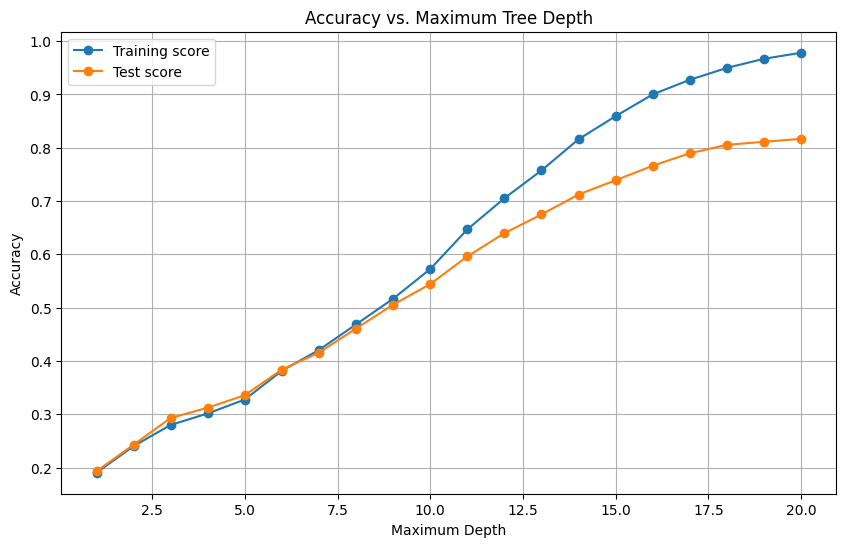


Optimal tree depth: 20
Final model accuracy: 0.8166

Final Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.59      0.63       549
           1       0.82      0.83      0.82       287
           2       0.83      0.83      0.83       609
           3       0.75      0.85      0.80       406
           4       0.84      0.87      0.86        92
           5       0.85      0.80      0.82        41
           6       0.87      0.87      0.87       922
           7       0.80      0.83      0.82       346
           8       0.95      0.95      0.95        22
           9       0.71      0.77      0.74       129
          10       0.86      0.87      0.86       128
          11       0.75      0.80      0.78        76
          12       0.79      0.81      0.80       371
          13       0.86      0.83      0.84       821
          14       0.73      0.92      0.81        12
          15       0.83      0.85      0.84       74

In [ ]:
print("Feature data types:")
print(X.dtypes)
print("\nTarget data types:")
print(y.dtypes)

# Convert categorical features to numerical
# Identify which columns are categorical
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()

print(f"\nCategorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")


if len(categorical_cols) > 0:
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded_features = encoder.fit_transform(X[categorical_cols])
    # Fit and transform categorical features

    # Convert to DataFrame
    encoded_df = pd.DataFrame(
        encoded_features,
        columns=encoder.get_feature_names_out(categorical_cols),
        index=X.index
    )

    # Combine with numerical features
    if len(numerical_cols) > 0:
        X_processed = pd.concat([X[numerical_cols], encoded_df], axis=1)
    else:
        X_processed = encoded_df
else:
    X_processed = X.copy()

if isinstance(y, pd.DataFrame):
# If y is a DataFrame, get its column name
    target_col = y.columns[0]  # Use the first column
    y_series = y[target_col]
else:
                               # If y is already a Series, use it directly
    y_series = y

# Convert target to numerical (if it's categorical)
if y_series.dtype == 'object':
    label_encoder = LabelEncoder()
    y_processed = label_encoder.fit_transform(y_series)
    # Store the class names for later use
    class_names = label_encoder.classes_
else:
    y_processed = y_series.values
    class_names = np.unique(y_processed).astype(str)

print("\nProcessed data shape:")
print(f"X_processed shape: {X_processed.shape}")
print(f"y_processed shape: {len(y_processed)}")

X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_processed, test_size=0.2, random_state=42)

# Create and train a decision tree with entropy criterion
dt_classifier = DecisionTreeClassifier(
    criterion='entropy',  # Use entropy to calculate information gain
    random_state=42,
    max_depth=16
)

# Train the model
dt_classifier.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = dt_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy of 16 based tree: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Determine the optimal number of tree levels
# Test different max_depth values
max_depths = range(1, 21)
train_scores = []
test_scores = []

for depth in max_depths:
    # Create and train tree with specific depth
    dt = DecisionTreeClassifier(criterion='entropy', max_depth=depth, random_state=42)
    dt.fit(X_train, y_train)

    # Evaluate on training and test sets
    train_pred = dt.predict(X_train)
    test_pred = dt.predict(X_test)
    train_scores.append(accuracy_score(y_train, train_pred))
    test_scores.append(accuracy_score(y_test, test_pred))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_scores, 'o-', label='Training score')
plt.plot(max_depths, test_scores, 'o-', label='Test score')
plt.xlabel('Maximum Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Maximum Tree Depth')
plt.legend()
plt.grid(True)
plt.show()

#Find optimal depth and train the final model
optimal_depth = max_depths[np.argmax(test_scores)]
print(f"\nOptimal tree depth: {optimal_depth}")

#Create final model with optimal depth
final_model = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=optimal_depth,
    random_state=42
)
final_model.fit(X_train, y_train)

# Evaluate the final model
final_pred = final_model.predict(X_test)
final_accuracy = accuracy_score(y_test, final_pred)
print(f"Final model accuracy: {final_accuracy:.4f}")
print("\nFinal Classification Report:")
print(classification_report(y_test, final_pred))

From the analysis of the performance metrics, we can see that increasing the depth available for the trees increased the accuracy. Despite this, the increment was only 0.05. There is a notable improvement in other metrics such as precision, recall, and f1-score.

According to the graph displayed, from a depth of 15 onward, the accuracy performance began to plateau. This is a clear example of overfitting.


The default parameters where:

*   min_samples_split=2
*   min_samples_leaf=1
*   max_features=None


Possible improvements might be seen when performing grid search to search for the best hyperparameters like min_samples_split, min_samples_leaf, and max_features because these parameters could help control the complexity of the tree and potentially mitigate overfitting while maintaining or improving performance. We focused on only one change to be able to track changes and also because the tree depth is one of the most influential factors in the bias-variance tradeoff.

Despite the intricated paths of chess, our tree found the way. The nature of chess makes this problem better solved by classifiers like this one, which integrate complex decision rules.

###K-Nearest Neighbors (KNN)







For knn models, given:
* $ X = \{x_1, x_2, \dots, x_n\} $: Training dataset with $ n $ data points.
* $ y = \{y_1, y_2, \dots, y_n\} $: Corresponding class labels for the training data points.
* $ x' $: A new instance (data point) whose class we want to predict.
* $ k $: Number of nearest neighbors to consider.

1. **Distance Metric**:
   The first step is to compute the distance between the new data point $ x' $ and all the training data points $ x_i $. Distance metrics that are usually used include:
   - **Euclidean Distance**:
$$
d(x', x_i) = \sqrt{\sum_{j=1}^{m} (x'_j - x_{ij})^2}
$$
     Where m is the number of features in each instance.

2. **Find the k Nearest Neighbors**:
   After calculating the distances, find the $ k $ training instances closest to $ x' $ based on the distance metric.


#### **Comparing Regression vs. Classification Approaches**

For the KNN implementation we will use two approaches:

*   Regression: where we define the target value as a continues variable
*   Categorical: where we define the  target value as categorical value.

The reason to do this is that one would think that each depth of win (for example, 3 moves, 4 moves, etc) would classify as one category each, which in a practical sense it can be done.

However this would assume, for example, that a depth of 3 moves is completely different from a depth of 4 moves, which is not true. In chess a win with that little difference in depth, 1 in this instance, could be assumed to have very similar positions. The further apart the depth of wins, the better the categories would be differentiated. Ignoring this fact can lead to miss- classification.

This is were the regression model is useful, as it not only takes majoritary voting among k neighbors to predict a class, but instead the nearest neighbors overall (regardless of its class value), and take an average over them to define the approximate depth of the solution. Meaning, for this case regression could be more suited for precision, where small differences should also be accounted for.

This doesn´t mean that a categorical approach is not useful, just that it can ignore certain datapoints even though their features were really similar to that of another data point with a different class, which can underrepresent a predicted class. However this can be compensated by the amount of data provided per class.

Another problem arises when trying to categorize following a regression, as depth of moves are integers, they can´t be decimals. To avoid this problem estimation to the nearest integer can be applied.

As not to assume any outcomes, for research reasons and even though we can make an educated guess of which model will be better at predicting minuscule variations. We will try both, and compare internally for knn, although this is out of scope for the HW.

However we will keep the classification one due to the assignment´s instructions.

Still, from the previous analysis, it can be seen that it is useful to notice the nature of the problem, as chess win depth is ordinal in nature,
thus regression models can also be really helpful to solve it.

---

#### **Why Use KNN for This Problem?**
KNN is a good choice for this problem because:
* It is distance-based: Chess positions have a natural numerical representation, and if not they can be mapped easily to have one. As they are distance based we can build clusters around each category based on the similarities of the position per datapoint (distance based)
* No need to fit to any function: Unlike linear models, KNN does not assume a specific function, it doesn´t need to find a fit to any.  
* Easy to interpret: We can inspect the neighbors influencing each prediction, and adjust accordingly.

---

#### **Hyperparameters That Affect KNN**
1. **k (Number of Neighbors)**: The most important parameter.
   * Low \( k \): More sensitive to noise (underfitted).
   * High \( k \): More generalized but may lose important patterns (overfitted).
2. **Distance Metric**: Usually Euclidean distance.

---

#### **KNN Regression**

KNN Regression predicts a continuous value by taking the average of the $ k $-nearest neighbors.

##### **Mathematical Formula**
$$
\hat{y} = \frac{1}{k} \sum_{i=1}^{k} y_i
$$
* $y_i$ are the actual depth of win of the k-nearest neighbors.
* $ k $ is the number of neighbors.
---
#### **KNN Classification**

KNN Classification predicts a category by majority voting, or assigining the most common class among its $k$- nearest neighbors.

##### **Mathematical Formula**

$$
\hat{y} = \arg\max_{c} \sum_{i=1}^{k} I(y_i = c)
$$

where:
* $ \hat{y} $ is the predicted class.
* $ c $ represents a possible class (e.g., "3 moves", "5 moves", etc.).
* $ I(y_i = c) $ is an **indicator function**:
  - $ I(y_i = c) = 1 $ if the $i $ the neighbor belongs to class $ c $.
  - $ I(y_i = c) = 0 $ otherwise.
* The $\arg\max$ function selects the class with the highest count among neighbors.

#### **Mapping categorical value columns to numerical values**

Before implementing any model we need to transform categorical valued columns to numerical valued columns in order to find the $k$- nearest neighbors. The transformation of the target values is just needed for the regression model, however there is no need to transform back when applying the classification model.

To do so, we did the following:

In [ ]:
# Create copies of X and y to modify for the KNN method section
X_knn = X.copy()
y_knn= y.copy()

In [ ]:
# Define a mapping for files (columns A-H now are 1-8)
file_mapping = {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8}

# Convert categorical file columns to numerical values
for col in X_knn.columns:
    if X_knn[col].dtype == 'object':  # If the column contains letters (A-H)
        X_knn[col] = X[col].map(file_mapping)

# Define a mapping for target variable (words to numbers)
target_mapping = {
    "one": 1, "two": 2, "three": 3, "four": 4, "five": 5, "six": 6,
    "seven": 7, "eight": 8, "nine": 9, "ten": 10, "eleven": 11, "twelve": 12,
    "thirteen": 13, "fourteen": 14, "fifteen": 15, "sixteen": 16, "zero": 0, "draw": -1
}

# Convert target variable to numerical values
y_knn['white-depth-of-win'] = y_knn['white-depth-of-win'].map(target_mapping)

# View mapped datasets
print("\nTransformed Dataset Sample:\n", X_knn.head())
print("\nTarget Variable Sample:\n", y_knn.head())


Transformed Dataset Sample:
    white-king-file  white-king-rank  white-rook-file  white-rook-rank  \
0                1                1                2                3   
1                1                1                3                1   
2                1                1                3                1   
3                1                1                3                1   
4                1                1                3                2   

   black-king-file  black-king-rank  
0                3                2  
1                3                2  
2                4                1  
3                4                2  
4                3                1  

Target Variable Sample:
    white-depth-of-win
0                  -1
1                  -1
2                  -1
3                  -1
4                  -1


####  **Implementing KNN Regression**

Now that our data is mapped to numerical data we implement the models. We will begin with the regression KNN model.

In [ ]:
# Stratified Split (80- 20) with random seed 42
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X_knn, y_knn, test_size=0.2, random_state=42, stratify= y_knn)

#Hyperparameter Tuning for k
k_values = range(1,21)
mse_scores = []

for k in k_values:
    knn_regressor = KNeighborsRegressor(n_neighbors=k)
    knn_regressor.fit(X_train, y_train_reg)
    y_pred_reg = knn_regressor.predict(X_test)
    mse = mean_squared_error(y_test_reg, y_pred_reg)
    mse_scores.append(mse)

#Choose best k (minimum MSE)
best_k = k_values[np.argmin(mse_scores)]
print(f"Best k: {best_k}")

#Train final KNN Regression Model
knn_regressor = KNeighborsRegressor(n_neighbors=best_k)
knn_regressor.fit(X_train, y_train_reg)
y_pred_reg = knn_regressor.predict(X_test)


#Evaluate Regression
mse = mean_squared_error(y_test_reg, y_pred_reg)
mae = mean_absolute_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")

Best k: 6
Mean Squared Error: 3.9649461471450067
Mean Absolute Error: 1.195177001663103
R-squared: 0.815484304890453


####  **Implementing KNN Classification**

Now we do the same but for the classification model. For practical purposes we will use Accuracy now to choose the best k as it is now a classification problem. However as the target value is ordinal in nature MSE would still work for this case.

In [ ]:
# Stratified Split (80- 20) with random seed 42
X_train, X_test, y_train, y_test = train_test_split(X_knn, y_knn, test_size=0.2, random_state=42, stratify= y_knn)

#Hyperparameter Tuning for k
k_values = range(1,21)
mse_scores_classifier = []
accuracy_scores = []

for k in k_values:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(X_train, y_train)
    y_pred_classifier = knn_classifier.predict(X_test)
    #mse_classifier = mean_squared_error(y_test,y_pred_classifier)
    #mse_scores_classifier.append(mse_classifier)
    acc_k = accuracy_score(y_test, y_pred_classifier)
    accuracy_scores.append(acc_k)

#Choose best k (minimum MSE)
#best_k_classifier_by_mse = k_values[np.argmin(mse_scores_classifier)]
#print(f"Best k: {best_k_classifier_by_mse}")

#Choose best k (highest accuracy)
best_k_classifier_by_accuracy = k_values[np.argmax(accuracy_scores)]
print(f"Best k: {best_k_classifier_by_accuracy}")

#Train final KNN Classification Model
knn_classifier = KNeighborsClassifier(n_neighbors=best_k_classifier_by_accuracy)
knn_classifier.fit(X_train, y_train)
y_pred_classifier = knn_classifier.predict(X_test)

#Evaluate Classification
accuracy = accuracy_score(y_test, y_pred_classifier)
precision = precision_score(y_test, y_pred_classifier, average='weighted')
recall = recall_score(y_test, y_pred_classifier, average='weighted')
f1 = f1_score(y_test, y_pred_classifier, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

Best k: 7


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy: 0.7646115466856735
Precision: 0.7684194054808182
Recall: 0.7646115466856735
F1 Score: 0.762477686304731


Now we compare the results from both models.

In [ ]:
# Store and compare results
results = pd.DataFrame({
    "Metric": ["Mean Squared Error", "Mean Absolute Error", "R² Score", "Accuracy", "Precision", "Recall", "F1 Score"],
    "Regression": [mse, mae, r2, None, None, None, None],
    "Classification": [None, None, None, accuracy, precision, recall, f1]
})

print(results)

                Metric  Regression  Classification
0   Mean Squared Error    3.964946             NaN
1  Mean Absolute Error    1.195177             NaN
2             R² Score    0.815484             NaN
3             Accuracy         NaN        0.764612
4            Precision         NaN        0.768419
5               Recall         NaN        0.764612
6             F1 Score         NaN        0.762478


We can interpret that both performed well from their scores. However, with a little ingenuity we could transform the predictions of the regression model into integer values, assume each one is a category, obtain its Accuracy, Precision, Recall, and F1 score, and now compare directly both models. It is not standard, but understanding the nature of the problem allows us for this type of exploration.

In [ ]:
#change predictions from regression to nearest integer
y_pred_reg_int =y_pred_reg.round().astype(int)

#Evaluate again regression, but with classification parameters
accuracy_2 = accuracy_score(y_test_reg, y_pred_reg_int)
precision_2 = precision_score(y_test_reg, y_pred_reg_int, average='weighted')
recall_2 = recall_score(y_test_reg, y_pred_reg_int, average='weighted')
f1_2 = f1_score(y_test_reg, y_pred_reg_int, average='weighted')

# Store and compare new results
results = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "Regression": [accuracy_2, precision_2, recall_2, f1_2],
    "Classification": [accuracy, precision, recall, f1]
})

print(results)

      Metric  Regression  Classification
0   Accuracy    0.477014        0.764612
1  Precision    0.591525        0.768419
2     Recall    0.477014        0.764612
3   F1 Score    0.479355        0.762478


This las step was just for exploratory reasons for the knn method. As expected, as a regression our model performs well according to our regression measures, however if we change the predictions into integers, the classification outperforms it. We can interpret the reasons for this by looking at the mean absolute error in our regression model, which is 1.19. This means that on average our results deviate at least 1 move in depth of win which considering we are trying to classify each depth of win independently as classes, it is a considerable difference.  Predicting, for example, between 13, and 14 depth of win with this absolute error would make it difficult for the regressionmodel to distinguish between the two.

This is further proven by the value of the knn regression converted to classifier, its accuracy is around .5, which can be broadly interpreted as the model being correct half of the time.

We thought that our regression model was going to be able to distinguish better between the nuances between classes that ordinaly are closer together, however this was not the case. The reason for this may be that as classes become closer, ordinaly speaking, their differences start to become blurry to the model when estimating values. This is not a problem for a classifier as it only votes out a majority of close neighbors.

We think that the regression for knn could perform better if we had more balanced classes.

Thus, although from the beginning we had a different hypthesis, that we were just going to stay with our knn classifier model, and the comparison was made out of curiosity, this supports the decision to stay with the classifier model.

---

The following measures are the ones reported for the knn classifier to compare with the other classifier models.


In [ ]:
# Store and compare new results
results = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "Classification": [accuracy, precision, recall, f1]
})

print(results)

      Metric  Classification
0   Accuracy        0.764612
1  Precision        0.768419
2     Recall        0.764612
3   F1 Score        0.762478


###Random Forest

Decision trees tend to be biased depending on the quality of the dataset. If there is a class imbalance, it will affect the way the tree is structured. They also often overfit to the training data, capturing noise rather than general patterns. One way to address these issues is to build multiple trees from different samples of the same dataset, creating a Random Forest. This way, with several paths leading to different (or similar) conclusions, we can obtain a more accurate prediction through majority voting.

Random Forest improves upon Decision Trees by introducing two key randomization techniques:

1.   **Bootstrap Sampling**: Each tree is trained on a different bootstrap sample by randomly drawing datasets with replacement from the training data, each sample the same size as the original training set. This can be done 𝑁 times, producing 𝑁 trees.

2.   **Feature Subsampling**: Instead of considering all features (𝑑) at each split, a random subset of 𝑚 features is selected (𝑚 < 𝑑).

Scikit-learn's Random Forest utilizes both, with $𝑚$ = $\sqrt{d}$ as default.

Once the trees are trained, their predictions are aggregated:

$$
\hat{y} = \arg\max_{k} \sum_{i=1}^{T} 1(y_i = k),
$$

where:
* $T$ is the number of trees,
* $k$ is a possible class, and
* $y_i$ is the prediction from tree $i$.

Using the conditions from the previously implemented Decision Tree, we use `max_depth` = 20, which was found to be the optimal depth.

The most important parameter in Random Forest is the number of trees to build, `n_estimators`. We will also find the optimal number of trees and keep the other parametes as default to have a direct benchmark.

Since our target variable is categorical, we use a classifier rather than a regressor even when we could transform the regression model predictions, as mentioned with KNN.

In [ ]:
# Create copies of X and y to modify for the Random Forest method section
X_rf = X.copy()
y_rf = y.copy()

# Using the same approach from KNN to change our categorical values into numerical in our features
for col in X_rf.columns:
    if X_rf[col].dtype == 'object':  # If the column contains letters (A-H)
        X_rf[col] = X[col].map(file_mapping)

# Labels also have to be numerical
label_encoder = LabelEncoder()
y_rfS = label_encoder.fit_transform(y_rf[y_rf.columns[0]])

In [ ]:
# Stratified Split (80- 20) with random seed 42
X_train, X_test, y_train, y_test = train_test_split(X_rf, y_rfS, test_size=0.2, random_state=42, stratify=y_rfS)

# Train model with optimal tree depth
rf = RandomForestClassifier(criterion='entropy', max_depth=optimal_depth, random_state=42)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)

accuracy_s = accuracy_score(y_test, pred)
precision_s = precision_score(y_test, pred, average='weighted')
recall_s = recall_score(y_test, pred, average='weighted')
f1_s = f1_score(y_test, pred, average='weighted')


As shown earlier, our dataset exhibits a significant class imbalance, making it an ideal case to demonstrate how a random forest can enhance the performance of decision trees. So now we will repeat the classification but with no stratification.

In [ ]:
# No stratification appplied
X_train, X_test, y_train, y_test = train_test_split(X_rf, y_rfS, test_size=0.2, random_state=42)

rf = RandomForestClassifier(criterion='entropy', max_depth=optimal_depth, random_state=42)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)

accuracy_no_s = accuracy_score(y_test, pred)
precision_no_s = precision_score(y_test, pred, average='weighted')
recall_no_s = recall_score(y_test, pred, average='weighted')
f1_no_s = f1_score(y_test, pred, average='weighted')


Now we compare the different implementations:


In [ ]:
results_rf = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "Stratification": [accuracy_s, precision_s, recall_s, f1_s],
    "No Stratification": [accuracy_no_s, precision_no_s, recall_no_s, f1_no_s]
})

print('\t\tRandom Forest Metrics\n')
print(results_rf)

		Random Forest Metrics

      Metric  Stratification  No Stratification
0   Accuracy        0.820919           0.831611
1  Precision        0.821683           0.833698
2     Recall        0.820919           0.831611
3   F1 Score        0.820411           0.831532


We will determine the optimal number of trees in the forest without using stratification, as it produced higher performance metrics.

In [ ]:
# Test different estimator values
n_estimators = range(50,550,50)
train_scores = []
test_scores = []

for e in n_estimators:
    # Create and train tree with specific number of estimators
    rf = RandomForestClassifier(criterion='entropy', n_estimators=e, max_depth=optimal_depth, random_state=42)
    rf.fit(X_train, y_train)

    # Evaluate on training and test sets
    train_pred = rf.predict(X_train)
    test_pred = rf.predict(X_test)
    train_scores.append(accuracy_score(y_train, train_pred))
    test_scores.append(accuracy_score(y_test, test_pred))

# Analyze behavior of the classifier with number of trees increment
round_test_scores = [round(num, 4) for num in test_scores]
n_est_acc = pd.DataFrame({
    'number of trees': n_estimators,
    'accuracy': round_test_scores
})
print(n_est_acc)

# Find optimal estimators and train the final model
optimal_e = n_estimators[np.argmax(test_scores)]
print(f"\n\nOptimal number of trees: {optimal_e}")

# Create final model with optimal estimators
final_model = RandomForestClassifier(
    criterion='entropy',
    n_estimators=optimal_e,
    max_depth=optimal_depth,
    random_state=42
)
final_model.fit(X_train, y_train)

# Evaluate the final model
final_pred = final_model.predict(X_test)

accuracy_rf = accuracy_score(y_test, final_pred)
precision_rf = precision_score(y_test, final_pred, average='weighted')
recall_rf = recall_score(y_test, final_pred, average='weighted')
f1_rf = f1_score(y_test, final_pred, average='weighted')


   number of trees  accuracy
0               50    0.8248
1              100    0.8316
2              150    0.8348
3              200    0.8332
4              250    0.8373
5              300    0.8341
6              350    0.8359
7              400    0.8370
8              450    0.8364
9              500    0.8357


Optimal number of trees: 250


After certain number of trees, any aditional tree will no longer have an impact in the behavior of the model. As we can observe, after 250 trees the accuracy scores no longer show significant change, and even tend to decrease. This behavior demonstrates that increasing the number of trees beyond a certain threshold does not meaningfully improve generalization.

In [ ]:
# Compare to default number of estimators
results_rf = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "Default Estimators (100)": [accuracy_no_s, precision_no_s, recall_no_s, f1_no_s],
    "Optimal Estimators (250)": [accuracy_rf, precision_rf, recall_rf, f1_rf]
})

print('\t\t\tRandom Forest Metrics\n')
print(results_rf)
print('\n\n\t\t\tClassification Report\n\n', classification_report(y_test, final_pred))

			Random Forest Metrics

      Metric  Default Estimators (100)  Optimal Estimators (250)
0   Accuracy                  0.831611                  0.837313
1  Precision                  0.833698                  0.839662
2     Recall                  0.831611                  0.837313
3   F1 Score                  0.831532                  0.837212


			Classification Report

               precision    recall  f1-score   support

           0       0.77      0.91      0.83       549
           1       0.86      0.83      0.84       287
           2       0.86      0.81      0.83       609
           3       0.80      0.89      0.84       406
           4       0.89      0.93      0.91        92
           5       0.97      0.73      0.83        41
           6       0.86      0.86      0.86       922
           7       0.84      0.85      0.84       346
           8       0.94      0.77      0.85        22
           9       0.79      0.74      0.77       129
          10       0.88  

## Discussion

We explored three supervised learning algorithms (**Decision Trees**, **K-Nearest Neighbors (KNN)**, and **Random Forest**) to analyze their classification performance on a given dataset.

The Decision Tree Classifier tend to overfit the training data, particularly when deep trees are allowed, but it is easy to train and interpret. The model was sensitive to class imbalance: it tends to favor majority-class predictions. Tuning hyperparameter `max_depth` to find its optimal value showed the overfitting behaviour and that the increased complexity at the optimal depth helps the model make better predictions.

The K-Nearest Neighbors (KNN) algorithm was evaluated as a non-parametric model that classifies new instances based on the majority vote of their 𝑘 nearest neighbors in feature space. The model's performance was highly dependent on the choice of 𝑘, with an optimal balance found after tuning. KNN is computationally expensive for large datasets since it requires distance calculations for each new prediction.

Random Forest improves Decision Trees by aggregating multiple trees trained on bootstrap samples of the data. This approach outperformed Decision Trees and KNN, achieving better generalization. Increasing the number of trees (n_estimators) stabilized results, but excessive trees led to almost imperceptible decreases in accuracy. The stratification impacted the model's performance, with the non-stratified split yielding slightly higher metrics, likely due to class distribution differences in the test set. This model appears to be the best choice to face this specific problem as it reduces variance and works better even with clear class imbalance, nonetheless, it is computationally expensive.

## Conclusions

In this notebook, we evaluated the performance of three classification algorithms: k-Nearest Neighbors (knn), Random Forest, and Decision Tree on a dataset derived from King-Rook vs. King chess endgame positions. The objective was to predict the depth of win class based on the board configuration given by the dataset features, and we used four measures to determine each model performance: accuracy, precision, recall, and F1 score.

Each measure demonstrated distinct characteristics:

* **Accuracy** gives a broad sense of correct predictions.

* **Precision** shows how often the model's predicted moves were actually correct.

* **Recall** measured the model’s ability to identify all relevant optimal moves.

* **F1 Score** offered a balance between precision and recall, particularly useful in evaluating imbalanced classes.

The best model was the Random Forest with a weighted accuracy of 0.84 and f1-score of 0.84 using 250 optimal estimators and a max_depth=20.

The differences in performance suggest that model choice should be informed by the specific goals of the application — whether prioritizing move precision (for example, in tactical play) or maximizing recall (for example, in training engines to suggest all viable options).

## Bibliographic references


1. Bain, M. & Hoff, A. (1994). Chess (King-Rook vs. King) [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C57W2S.
2. Capablanca, J. R. (1921). Chess fundamentals. Harcourt, Brace and Company.
3. Kulatilleke, G. K., & Samarakoon, S. (2022). Empirical study of Machine Learning Classifier Evaluation Metrics behavior in Massively Imbalanced and Noisy data. arXiv preprint arXiv:2208.11904.
4. Hastie, T., Tibshirani, R., & Friedman, J. (2009). The elements of statistical learning: Data mining, inference, and prediction (2nd ed.). Springer Science & Business Media.
5. Cover, T. M., & Hart, P. E. (1967). Nearest neighbor pattern classification. IEEE Transactions on Information Theory, 13(1), 21–27. https://doi.org/10.1109/TIT.1967.1053964
6. Altman, N. S. (1992). An introduction to kernel and nearest-neighbor nonparametric regression. The American Statistician, 46(3), 175–185. https://doi.org/10.1080/00031305.1992.10475879